In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print len(df)
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
939400,313,ARAXÁ,1018.0,-19.605696,-46.949617,A505,Araxá,MG,2007-01-14 16:00:00,2007-01-14,...,26.2,20.7,23.8,18.7,70.0,78.0,65.0,4.0,313.0,8.8
8868813,411,JOSÉ BONIFÁCIO,408.0,-21.085675,-49.920388,A735,José Bonifácio,SP,2011-01-29 13:00:00,2011-01-29,...,28.1,22.5,26.3,20.3,70.0,78.0,65.0,1.3,305.0,4.4
3393031,339,MARIA DA FÉ,1281.0,-22.314567,-45.373049,A531,Maria da Fé,MG,2012-01-13 07:00:00,2012-01-13,...,16.0,15.6,15.6,15.3,98.0,98.0,98.0,0.4,281.0,1.3


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
df.sample(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
2783939,406,LINS,461.0,-21.666045,-49.734854,A727,Lins,SP,2014-02-09 11:00:00,2014-02-09,...,26.8,17.9,24.2,16.5,59.0,66.0,56.0,1.5,122.0,4.2
451151,316,ALMENARA,189.0,-16.166773,-40.687756,A508,Almenara,MG,2013-02-06 23:00:00,2013-02-06,...,28.5,19.0,27.9,17.5,58.0,58.0,52.0,6.3,87.0,9.8
1736669,363,IBIRITÈ (ROLA MOÇA),1199.0,-20.031457,-44.011249,A555,Ibirité,MG,2009-03-21 05:00:00,2009-03-21,...,19.7,14.6,18.1,14.2,77.0,79.0,71.0,0.2,0.0,9.0
205199,309,PRES. KENNEDY,69.0,-21.100805,-41.039395,A622,Presidente Kennedy,ES,2011-01-28 23:00:00,2011-01-28,...,25.6,20.8,25.2,20.6,76.0,76.0,74.0,7.1,59.0,11.8


# Pré-processamento

<h3>Dados ausentes</h3>

In [8]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [9]:
missing_values_count[missing_values_count > 0.1]

prcp    81.451521
gbrd    41.773469
wdsp     9.086096
gust     2.863085
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [10]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [11]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [12]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [13]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

dewp    0.000468
dmax    0.000499
dmin    0.000592
hmin    0.000873
dtype: float64

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [14]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [15]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

In [16]:
cols_with_missing = list((col for col in df[V].columns 
                                 if df[col].isnull().any()))

In [17]:
cols_with_missing

['dewp', 'dmax', 'dmin', 'hmin']

In [18]:
for col in cols_with_missing:
    df[col + '_was_missing'] = df[col].isnull()

In [19]:
NEW = ['dewp_was_missing', 'dmax_was_missing', 'dmin_was_missing', 'hmin_was_missing']

<p>Listando alguns exemplos com dados ausentes</p>

In [20]:
x = df[(df['dewp_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534891,0.0,957.0,957.4,957.0,22.4,NaN,22.7,1.6,22.4,NaN,23.0,25.0,23.0,0.0,0.0,0.0
2255000,0.0,895.0,895.0,894.6,10.3,NaN,10.8,0.4,10.2,-0.3,49.0,49.0,48.0,0.3,330.0,0.5
2255019,0.0,896.6,897.3,896.6,15.3,NaN,15.9,0.8,14.9,-1.0,35.0,36.0,33.0,0.6,291.0,1.8
2255570,0.0,897.2,897.4,897.2,20.4,NaN,21.6,1.1,20.4,-0.2,26.0,27.0,24.0,2.9,70.0,6.1
2255571,0.0,897.0,897.2,897.0,20.6,NaN,20.8,0.3,20.0,-0.8,25.0,26.0,25.0,3.2,59.0,6.0
2549620,0.0,1013.0,1013.6,1013.0,21.4,NaN,21.5,NaN,21.1,-0.7,24.0,24.0,23.0,0.0,77.0,1.8
2549624,0.0,1012.7,1012.7,1012.2,19.9,NaN,20.0,NaN,19.8,-0.5,26.0,26.0,26.0,0.0,79.0,0.3
2820887,0.0,955.1,955.1,954.5,25.1,NaN,26.3,NaN,25.1,0.0,19.0,19.0,0.0,1.3,158.0,5.7
2820981,5.0,954.5,954.5,954.0,25.6,NaN,27.9,0.3,23.6,0.0,19.0,20.0,0.0,0.9,325.0,9.0
2914423,0.0,961.8,961.9,961.6,21.4,NaN,21.7,4.8,20.9,-0.1,24.0,34.0,24.0,1.4,81.0,1.8


In [21]:
NEW

['dewp_was_missing',
 'dmax_was_missing',
 'dmin_was_missing',
 'hmin_was_missing']

In [22]:
df['dewp'] = df['dewp'].fillna(df['dmin'])
df['dewp'] = df['dewp'].fillna(df['dmax'])

<p>Para <b>ponto de orvalho MÁXIMO </b> vou preencher o valor com o valor da ponto de orvalho da instância, visto que são pouquissímos casos</p>

In [23]:
x = df.groupby(['wsid']).dmax_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
319    1
372    1
385    1
398    3
408    6
411    1
418    3
Name: dmax_was_missing, dtype: int64

In [24]:
df['dmax'] = df['dmax'].fillna(df['dewp'])
df['dmax'] = df['dmax'].fillna(df['dmin'])

In [25]:
x = df[(df['dmax_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534869,0.0,956.7,956.7,956.3,20.4,-1.0,21.5,-1.0,20.1,-1.3,24.0,24.0,24.0,0.0,0.0,0.0
1874270,0.0,1011.5,1011.8,1011.5,28.0,0.0,28.2,0.0,25.8,0.0,0.0,17.0,0.0,4.7,124.0,6.5
2255020,0.2,896.3,896.6,896.2,14.4,-0.9,15.3,-0.9,14.2,-1.6,35.0,35.0,33.0,0.4,34.0,1.3
2549620,0.0,1013.0,1013.6,1013.0,21.4,-0.7,21.5,-0.7,21.1,-0.7,24.0,24.0,23.0,0.0,77.0,1.8
2549621,1.2,1012.7,1013.0,1012.6,21.3,-0.4,21.4,-0.4,21.2,-0.4,24.0,24.0,24.0,0.0,78.0,1.8
2549624,0.0,1012.7,1012.7,1012.2,19.9,-0.5,20.0,-0.5,19.8,-0.5,26.0,26.0,26.0,0.0,79.0,0.3
2820673,0.2,957.7,957.7,956.9,22.4,0.0,22.4,0.0,22.2,0.0,0.0,23.0,0.0,0.0,129.0,1.8
2820885,0.0,953.7,953.8,953.6,27.9,-0.6,28.0,-0.6,27.0,0.0,16.0,17.0,0.0,0.0,273.0,4.0
2820887,0.0,955.1,955.1,954.5,25.1,0.0,26.3,0.0,25.1,0.0,19.0,19.0,0.0,1.3,158.0,5.7
2820894,0.0,955.9,956.2,955.9,22.4,-1.8,23.3,-1.8,22.3,-2.5,20.0,21.0,19.0,0.7,28.0,2.1


<p>Para <b>ponto de orvalho MINIMO</b> vou preencher o valor com o valor da temperatura do ponto de orvalho minima da instância, visto que são pouquissímos casos</p>

In [26]:
x = df.groupby(['wsid']).dmin_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
319    2
358    1
379    1
385    3
408    2
411    7
417    1
418    2
Name: dmin_was_missing, dtype: int64

In [27]:
df['dmin'] = df['dmin'].fillna(df['dewp'])

In [28]:
x = df[(df['dmin_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534865,0.0,957.5,957.5,957.1,21.3,0.1,21.6,0.5,21.1,0.1,24.0,25.0,24.0,0.0,0.0,0.0
534891,0.0,957.0,957.4,957.0,22.4,1.6,22.7,1.6,22.4,1.6,23.0,25.0,23.0,0.0,0.0,0.0
1618218,0.0,978.4,979.3,978.4,35.7,8.6,36.4,9.0,35.4,8.6,19.0,19.0,10.0,1.9,60.0,5.0
2100700,0.0,825.3,825.9,825.3,15.1,0.8,15.1,1.4,14.7,0.8,38.0,40.0,36.0,4.4,76.0,7.9
2255016,0.0,897.5,897.5,896.7,15.9,0.4,17.6,1.4,15.9,0.4,35.0,35.0,33.0,0.5,322.0,4.6
2255561,0.0,896.3,896.8,896.3,24.3,1.7,25.4,3.3,24.1,1.7,23.0,25.0,20.0,3.7,69.0,9.2
2255566,0.0,895.7,895.7,895.3,22.4,1.5,23.3,1.5,22.1,1.5,25.0,25.0,22.0,2.8,37.0,7.7
2820891,0.0,957.2,957.2,956.8,24.1,0.2,24.6,1.3,24.1,0.2,21.0,22.0,20.0,1.2,8.0,2.6
2820920,0.0,956.6,956.7,956.5,23.3,1.8,23.4,1.8,23.1,1.8,24.0,24.0,21.0,1.1,340.0,4.3
2919702,0.0,965.5,965.7,965.5,22.0,0.1,22.1,3.9,21.6,0.1,23.0,31.0,23.0,0.7,24.0,1.8


<p>Para <b>humidade MINIMA</b> vou preencher o valor com o valor da humidade do ponto de orvalho minima da instância, visto que são pouquissímos casos</p>

In [29]:
x = df.groupby(['wsid']).hmin_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
372    28
Name: hmin_was_missing, dtype: int64

In [30]:
df['hmin'] = df['hmin'].fillna(df['hmdy'])

In [31]:
x = df[(df['hmin_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1851676,0.2,1007.2,1008.0,1007.2,22.6,-7.0,22.9,20.5,22.5,0.0,0.0,87.0,0.0,3.3,315.0,6.5
1851677,0.4,1006.8,1007.2,1006.8,21.6,-4.9,22.7,11.7,21.6,0.0,0.0,55.0,0.0,3.0,330.0,6.4
1851678,0.8,1006.5,1006.9,1006.5,20.8,0.0,21.7,14.1,20.8,0.0,0.0,65.0,0.0,2.7,331.0,4.3
1851679,1.0,1005.7,1006.6,1005.7,20.9,0.0,21.0,0.0,20.4,0.0,0.0,21.0,0.0,3.2,18.0,5.5
1851680,1.6,1005.5,1005.9,1005.5,20.9,0.0,21.0,0.0,20.4,0.0,0.0,11.0,0.0,4.5,8.0,7.8
1851681,2.0,1005.4,1005.6,1005.3,20.6,0.0,21.0,0.0,20.3,0.0,0.0,20.0,0.0,2.0,23.0,5.0
1851682,0.2,1005.0,1005.4,1004.9,21.2,0.0,21.2,13.4,20.0,0.0,0.0,67.0,0.0,3.3,360.0,5.7
1851683,0.0,1005.6,1005.6,1004.9,22.1,0.0,22.5,0.0,21.1,0.0,0.0,2.0,0.0,2.5,344.0,7.8
1851684,0.2,1006.0,1006.1,1005.5,21.9,0.0,22.6,0.0,21.9,0.0,0.0,11.0,0.0,2.9,320.0,6.7
1851685,0.2,1005.5,1006.0,1005.2,22.9,0.0,22.9,0.0,21.7,0.0,0.0,34.0,0.0,5.4,338.0,7.9


In [32]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Retirando as colunas marcadoras de nulos</p>

In [33]:
for col in NEW:
    df = df.drop(col,1)

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [34]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [35]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [36]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
dewp,3206856.0,17.297680,5.658427,-10.0,16.6,18.7,20.5,42.0
tmax,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dmax,3206856.0,17.823457,5.776795,-10.0,17.2,19.3,21.0,44.8
tmin,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206856.0,16.782823,5.583940,-10.0,16.0,18.2,20.0,44.9


In [37]:
df[cols] = df[cols].replace({0.0:np.nan})

In [38]:
print len(df)
df  = df.dropna()
print len(df)

3206856
2839909


<p>Verificando os mínimos e máximos por região.</p>

In [39]:
for r in ['ES','RJ','SP','MG']:
    x = df[df['prov'] == r]
    print 'Estado %s' % r 
    print x[V].describe().T

Estado ES
         count        mean         std    min    25%     50%     75%     max
prcp  220655.0    0.204863    1.433453    0.0    0.0     0.0     0.0    96.8
stp   220655.0  991.383966   33.815210  894.3  995.6  1005.3  1010.3  1020.8
smax  220655.0  991.628418   33.823002  895.0  995.8  1005.6  1010.6  1020.9
smin  220655.0  991.139060   33.806708  894.2  995.3  1005.1  1010.1  1020.6
temp  220655.0   25.524657    3.975315   13.4   22.9    25.0    28.2    43.5
dewp  220655.0   20.514934    2.030043    5.3   19.3    20.8    22.0    35.0
tmax  220655.0   26.166317    4.197098   13.6   23.3    25.5    29.1    45.0
dmax  220655.0   21.043374    1.941605    8.9   19.9    21.3    22.4    35.7
tmin  220655.0   24.934530    3.755366   13.2   22.5    24.5    27.4    42.3
dmin  220655.0   20.010522    2.138492    3.6   18.7    20.4    21.6    33.6
hmdy  220655.0   76.254524   16.942884   13.0   64.0    80.0    91.0   100.0
hmax  220655.0   78.971879   15.745875   15.0   68.0    83.0    92

<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [40]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

('tmin>tmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('hmin>hmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('smin>smax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('dmin>dmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])


<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [41]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [97]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

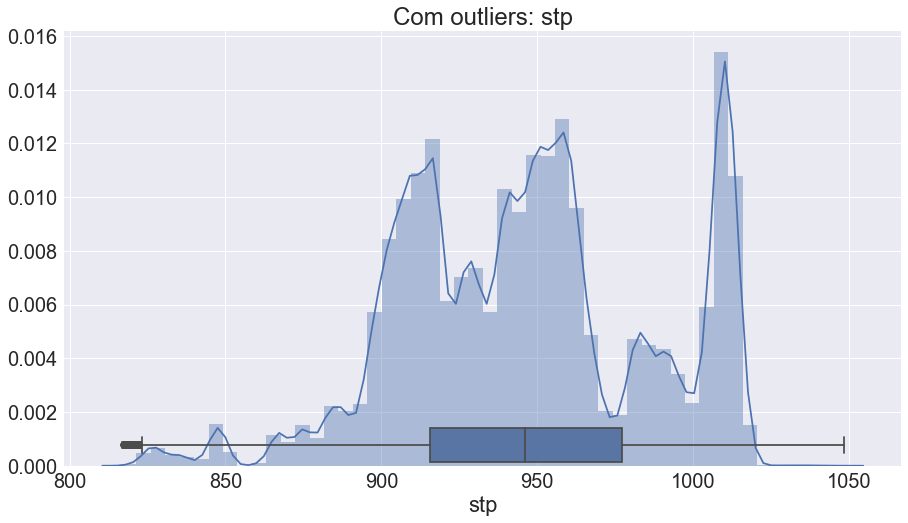

In [98]:
bp('stp')

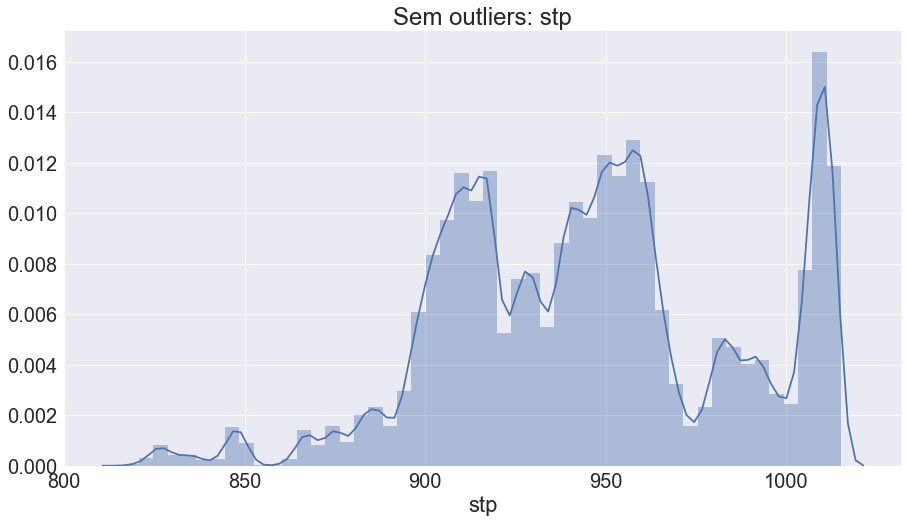

In [99]:
bp_sem('stp')

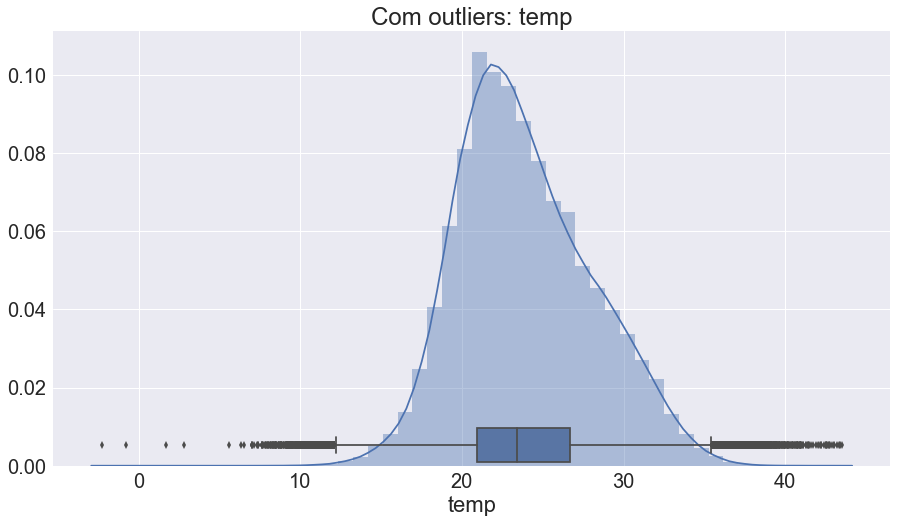

In [100]:
bp('temp')

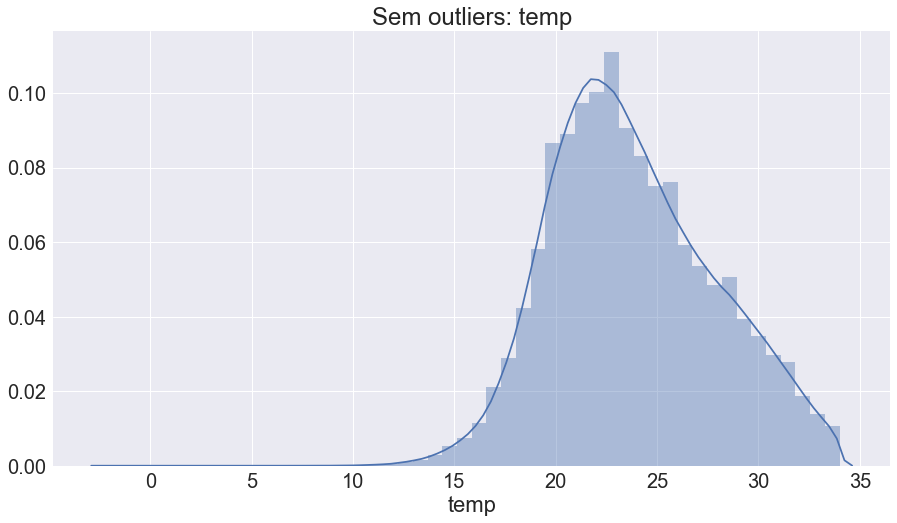

In [101]:
bp_sem('temp')

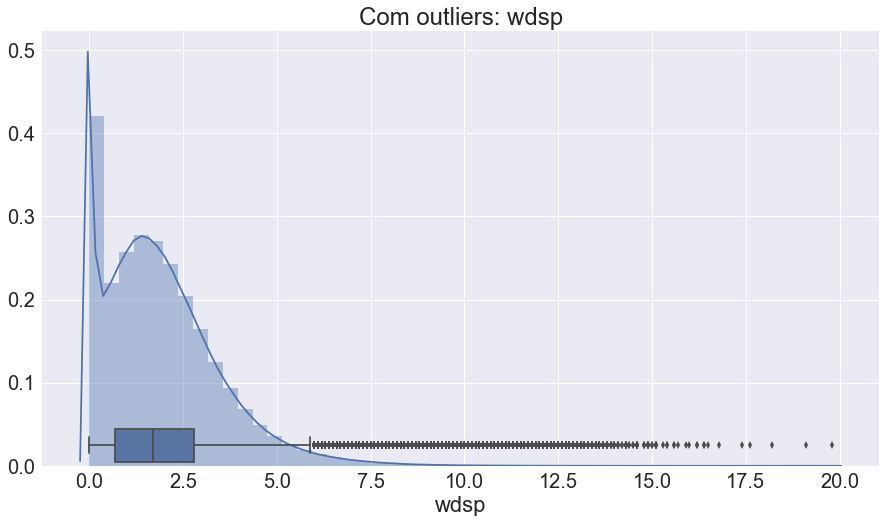

In [102]:
bp('wdsp')

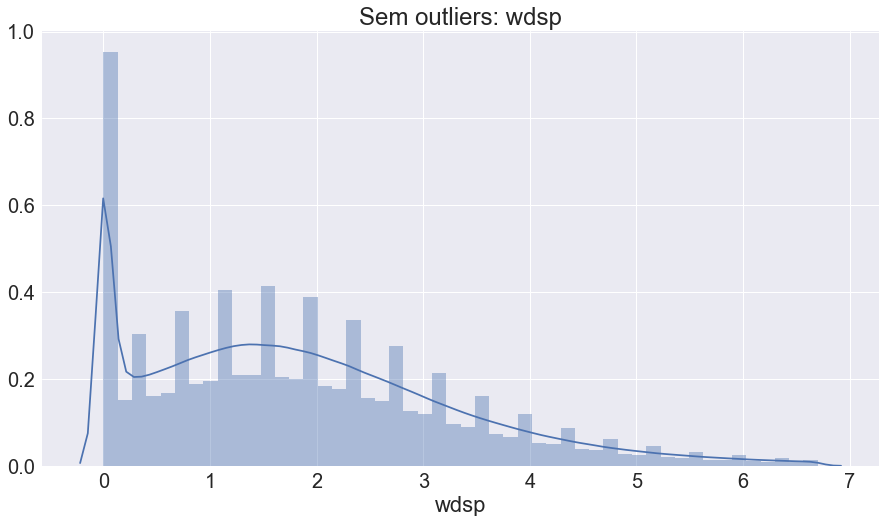

In [104]:
bp_sem('wdsp')

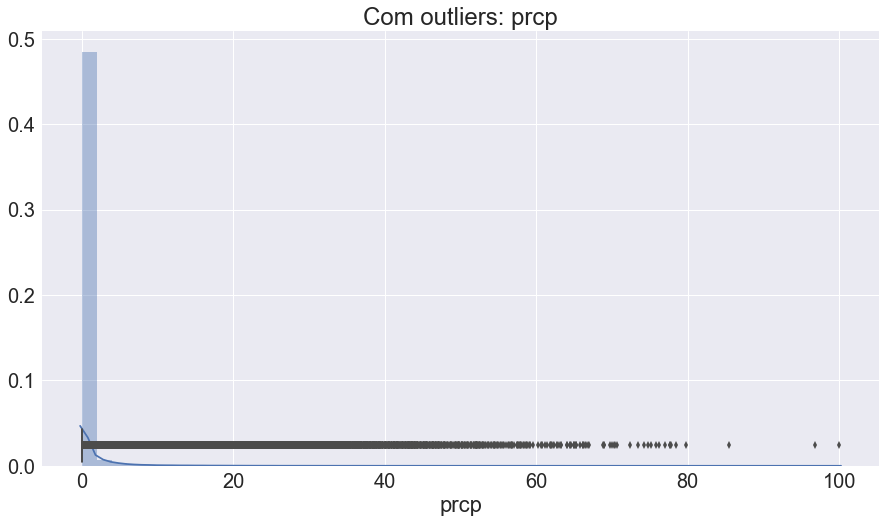

In [106]:
bp('prcp')

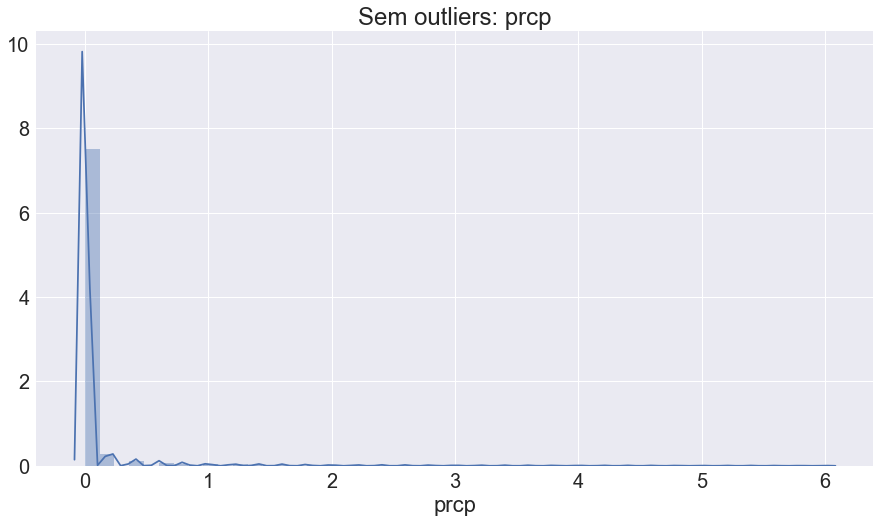

In [105]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [116]:
dfm = backup_df() 

In [117]:
len(dfm)

3206856

In [118]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1742376,363,1199.0,-20.031457,-44.011249,2011-03-17 00:00:00,0.2,882.8,882.8,882.1,19.6,...,19.9,18.4,19.5,18.0,92.0,92.0,90.0,4.0,54.0,10.0
271922,312,1169.0,-21.228373,-43.767703,2007-01-23 02:00:00,0.2,887.8,888.6,887.7,16.8,...,16.9,15.9,16.7,15.7,94.0,94.0,94.0,1.1,146.0,5.3
2187260,382,3.0,-23.223540,-44.726863,2011-03-20 20:00:00,0.2,1016.1,1016.1,1015.8,23.4,...,24.0,22.3,23.3,21.7,92.0,92.0,90.0,1.2,265.0,1.9
3145867,420,540.0,-21.338432,-48.114007,2014-12-10 19:00:00,0.0,948.7,949.4,948.7,24.7,...,26.8,20.4,24.7,18.7,72.0,72.0,64.0,4.0,359.0,7.7
1806945,371,35.0,-22.757868,-43.684843,2003-01-01 09:00:00,0.0,1006.2,1006.2,1005.3,27.0,...,27.0,20.8,26.3,20.6,68.0,71.0,68.0,2.4,273.0,6.5


In [119]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[178, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423]


In [120]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [121]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,6,NON_DER)

In [122]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [123]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [124]:
dfr.sample(3)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_3,dmax_4,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6
2642898,401,676.0,-23.852022,-48.164817,2015-12-17 18:00:00,0.0,936.8,937.4,936.8,28.0,...,20.2,20.5,19.5,19.2,0.0,0.0,0.0,0.0,0.0,0.0
1082130,338,1077.0,-21.918066,-46.382996,2009-12-17 18:00:00,0.0,893.6,894.2,893.6,27.6,...,18.2,19.1,18.8,18.6,0.0,0.0,0.0,0.0,0.0,0.0
1323604,347,454.0,-15.085958,-44.016036,2010-12-28 04:00:00,0.0,957.2,957.8,957.2,21.6,...,21.3,21.2,21.7,22.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
dfr.columns

Index([u'wsid', u'elvt', u'lat', u'lon', u'mdct', u'prcp', u'stp', u'smax',
       u'smin', u'temp',
       ...
       u'dmax_3', u'dmax_4', u'dmax_5', u'dmax_6', u'prcp_1', u'prcp_2',
       u'prcp_3', u'prcp_4', u'prcp_5', u'prcp_6'],
      dtype='object', length=123)

In [154]:
dfm = dfr

In [155]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 '

In [156]:
len(dfm)

3206856

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [157]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [158]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [159]:
print len(dfm)
dfm  = dfm.dropna()
print len(dfm)

3206856
2776302


In [160]:
dfm = dfm.reset_index(drop=True)

In [161]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_3,dmax_4,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6
0,178,237.0,-6.835777,-38.311583,2007-12-01 16:00:00,0.0,982.6,983.6,982.6,33.2,...,16.4,17.9,18.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,237.0,-6.835777,-38.311583,2007-12-01 17:00:00,0.0,981.7,982.6,981.7,34.4,...,15.8,16.4,17.9,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,178,237.0,-6.835777,-38.311583,2007-12-01 18:00:00,0.0,981.3,981.7,981.3,34.8,...,14.2,15.8,16.4,17.9,0.0,0.0,0.0,0.0,0.0,0.0
3,178,237.0,-6.835777,-38.311583,2007-12-01 19:00:00,0.0,981.0,981.3,981.0,35.0,...,13.7,14.2,15.8,16.4,0.0,0.0,0.0,0.0,0.0,0.0
4,178,237.0,-6.835777,-38.311583,2007-12-01 20:00:00,0.0,981.0,981.0,980.9,33.0,...,13.5,13.7,14.2,15.8,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776302 entries, 0 to 2776301
Columns: 123 entries, wsid to prcp_6
dtypes: float64(115), int64(1), object(7)
memory usage: 2.5+ GB


In [163]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [164]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',


In [165]:
REMOVE = [u'mdct',u'mdct_1', u'mdct_2', u'mdct_3', u'mdct_4', u'mdct_5', u'mdct_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [166]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 '

<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [170]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [171]:
target = 'temp'

In [172]:
X =  dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [173]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print len(X_train)
print len(X_tmp)

2498671
277631


<p>Separando o conjunto de testes</p>

In [174]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2)

In [175]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   2498671, Training features   115
Validation instances 55527, Validation features 115
Testing instances    222104, Testing features    115


In [176]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [177]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [193]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_model_03')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118f45110>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_model_03', '_save_summary_steps': 100}


In [194]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [195]:
evaluations = []  
STEPS = 500  

for i in range(1, up):
    
    regressor.train(
        input_fn=wx_input_fn(X_train
                            ,y_train)
        , steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 129072190.0, step = 1
INFO:tensorflow:global_step/sec: 8.39752
INFO:tensorflow:loss = 79278.414, step = 101 (11.909 sec)
INFO:tensorflow:global_step/sec: 8.39512
INFO:tensorflow:loss = 68139.51, step = 201 (11.913 sec)
INFO:tensorflow:global_step/sec: 8.38683
INFO:tensorflow:loss = 58976.305, step = 301 (11.921 sec)
INFO:tensorflow:global_step/sec: 8.05659
INFO:tensorflow:loss = 49683.39, step = 401 (12.413 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 45011.387.
INFO:tensorflow:Starting evaluation at 2018-04-06-04:38:50
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-500
INFO:tensorflow:Finished evaluation at 2018-04-06-04:38:57
INFO:tensorflow:Saving dict for global step 500: average_loss = 45.436874, global_step = 500, loss = 45053.094
INFO:tensorflo

INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-4000
INFO:tensorflow:Finished evaluation at 2018-04-06-04:49:13
INFO:tensorflow:Saving dict for global step 4000: average_loss = 8.05956, global_step = 4000, loss = 7991.4854
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 8012.4556, step = 4001
INFO:tensorflow:global_step/sec: 8.05969
INFO:tensorflow:loss = 7404.9375, step = 4101 (12.408 sec)
INFO:tensorflow:global_step/sec: 8.44301
INFO:tensorflow:loss = 7488.164, step = 4201 (11.844 sec)
INFO:tensorflow:global_step/sec: 8.42397
INFO:tensorflow:loss = 7485.2974, step = 4301 (11.872 sec)
INFO:tensorflow:global_step/sec: 8.39629
INFO:tensorflow:loss = 7471.368, step = 4401 (11.909 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step:

INFO:tensorflow:loss = 5514.8086, step = 7801 (12.140 sec)
INFO:tensorflow:global_step/sec: 8.21988
INFO:tensorflow:loss = 5556.778, step = 7901 (12.164 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 5487.746.
INFO:tensorflow:Starting evaluation at 2018-04-06-05:00:47
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-04-06-05:00:54
INFO:tensorflow:Saving dict for global step 8000: average_loss = 5.5727687, global_step = 8000, loss = 5525.6987
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 5289.676, step = 8001
INFO:tensorflow:global_step/sec: 8.21992
INFO:tensorflow:loss = 5779.4004, step = 8101 (12.166 sec)
INFO:tensorflow:global_step/sec: 8.36813
INFO:tensorflow:loss = 5495.

INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 4454.752, step = 11501
INFO:tensorflow:global_step/sec: 8.48951
INFO:tensorflow:loss = 4428.7886, step = 11601 (11.781 sec)
INFO:tensorflow:global_step/sec: 8.68594
INFO:tensorflow:loss = 5481.726, step = 11701 (11.513 sec)
INFO:tensorflow:global_step/sec: 8.69039
INFO:tensorflow:loss = 4543.7544, step = 11801 (11.507 sec)
INFO:tensorflow:global_step/sec: 8.60809
INFO:tensorflow:loss = 4732.7026, step = 11901 (11.617 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 4466.323.
INFO:tensorflow:Starting evaluation at 2018-04-06-05:12:15
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-12000
INFO:tensorflow:Finished evaluation at 2018-04-06-05:12:23
INFO:tensorflow:Saving dict for global step 12000: average_loss = 4.6563473, global_step = 12000, loss = 4617.018
INFO:tensorflow:Create CheckpointSaver

INFO:tensorflow:Starting evaluation at 2018-04-06-05:22:10
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-15500
INFO:tensorflow:Finished evaluation at 2018-04-06-05:22:17
INFO:tensorflow:Saving dict for global step 15500: average_loss = 4.158403, global_step = 15500, loss = 4123.2793
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-15500
INFO:tensorflow:Saving checkpoints for 15501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 4044.055, step = 15501
INFO:tensorflow:global_step/sec: 8.22382
INFO:tensorflow:loss = 4463.875, step = 15601 (12.161 sec)
INFO:tensorflow:global_step/sec: 8.45735
INFO:tensorflow:loss = 4436.5156, step = 15701 (11.824 sec)
INFO:tensorflow:global_step/sec: 8.34719
INFO:tensorflow:loss = 3965.6, step = 15801 (11.981 sec)
INFO:tensorflow:global_step/sec: 8.44022
INFO:tensorflow:loss = 4233.539, step = 15901 (11.850 sec)
INFO:tensorflow:Saving checkpoints for 16000 int

INFO:tensorflow:global_step/sec: 8.47634
INFO:tensorflow:loss = 3781.8542, step = 19201 (11.798 sec)
INFO:tensorflow:global_step/sec: 8.59073
INFO:tensorflow:loss = 3518.1536, step = 19301 (11.642 sec)
INFO:tensorflow:global_step/sec: 8.56997
INFO:tensorflow:loss = 3801.4834, step = 19401 (11.667 sec)
INFO:tensorflow:Saving checkpoints for 19500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 3806.6785.
INFO:tensorflow:Starting evaluation at 2018-04-06-05:33:22
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-19500
INFO:tensorflow:Finished evaluation at 2018-04-06-05:33:29
INFO:tensorflow:Saving dict for global step 19500: average_loss = 3.7538185, global_step = 19500, loss = 3722.112
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-19500
INFO:tensorflow:Saving checkpoints for 19501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 3429.3638, step = 19501
INFO:tensorflow:

INFO:tensorflow:Saving dict for global step 23000: average_loss = 3.4812968, global_step = 23000, loss = 3451.8923
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-23000
INFO:tensorflow:Saving checkpoints for 23001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 3319.3003, step = 23001
INFO:tensorflow:global_step/sec: 8.28843
INFO:tensorflow:loss = 3394.981, step = 23101 (12.066 sec)
INFO:tensorflow:global_step/sec: 8.51616
INFO:tensorflow:loss = 3224.0771, step = 23201 (11.742 sec)
INFO:tensorflow:global_step/sec: 8.41195
INFO:tensorflow:loss = 3404.4858, step = 23301 (11.888 sec)
INFO:tensorflow:global_step/sec: 8.40113
INFO:tensorflow:loss = 3573.4126, step = 23401 (11.903 sec)
INFO:tensorflow:Saving checkpoints for 23500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 3070.8677.
INFO:tensorflow:Starting evaluation at 2018-04-06-05:44:39
INFO:tensorflow:Restoring parameters from /tmp/tf_

INFO:tensorflow:global_step/sec: 8.67302
INFO:tensorflow:loss = 3137.258, step = 26901 (11.528 sec)
INFO:tensorflow:Saving checkpoints for 27000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 3396.3584.
INFO:tensorflow:Starting evaluation at 2018-04-06-05:54:30
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-27000
INFO:tensorflow:Finished evaluation at 2018-04-06-05:54:37
INFO:tensorflow:Saving dict for global step 27000: average_loss = 3.2313454, global_step = 27000, loss = 3204.0522
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-27000
INFO:tensorflow:Saving checkpoints for 27001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 3218.9536, step = 27001
INFO:tensorflow:global_step/sec: 8.46285
INFO:tensorflow:loss = 3190.4316, step = 27101 (11.818 sec)
INFO:tensorflow:global_step/sec: 8.6534
INFO:tensorflow:loss = 3294.433, step = 27201 (11.556 sec)
INFO:tensorflow:gl

INFO:tensorflow:Saving checkpoints for 30501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 3117.6782, step = 30501
INFO:tensorflow:global_step/sec: 8.41416
INFO:tensorflow:loss = 3297.992, step = 30601 (11.885 sec)
INFO:tensorflow:global_step/sec: 8.50169
INFO:tensorflow:loss = 3188.0154, step = 30701 (11.762 sec)
INFO:tensorflow:global_step/sec: 8.52839
INFO:tensorflow:loss = 3112.3765, step = 30801 (11.726 sec)
INFO:tensorflow:global_step/sec: 8.52081
INFO:tensorflow:loss = 2872.4436, step = 30901 (11.736 sec)
INFO:tensorflow:Saving checkpoints for 31000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2931.8755.
INFO:tensorflow:Starting evaluation at 2018-04-06-06:05:41
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-31000
INFO:tensorflow:Finished evaluation at 2018-04-06-06:05:48
INFO:tensorflow:Saving dict for global step 31000: average_loss = 3.0241246, global_step = 31000, loss = 2998.5815
INFO:tensorflow:Create CheckpointSa

INFO:tensorflow:Starting evaluation at 2018-04-06-06:15:31
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-34500
INFO:tensorflow:Finished evaluation at 2018-04-06-06:15:38
INFO:tensorflow:Saving dict for global step 34500: average_loss = 2.8651817, global_step = 34500, loss = 2840.981
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-34500
INFO:tensorflow:Saving checkpoints for 34501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 3002.7012, step = 34501
INFO:tensorflow:global_step/sec: 8.34469
INFO:tensorflow:loss = 2912.3047, step = 34601 (11.985 sec)
INFO:tensorflow:global_step/sec: 8.5108
INFO:tensorflow:loss = 2722.208, step = 34701 (11.750 sec)
INFO:tensorflow:global_step/sec: 8.51572
INFO:tensorflow:loss = 2993.5154, step = 34801 (11.743 sec)
INFO:tensorflow:global_step/sec: 8.49163
INFO:tensorflow:loss = 3055.3506, step = 34901 (11.776 sec)
INFO:tensorflow:Saving checkpoints for 35000

INFO:tensorflow:global_step/sec: 8.62892
INFO:tensorflow:loss = 3121.6504, step = 38201 (11.589 sec)
INFO:tensorflow:global_step/sec: 8.65028
INFO:tensorflow:loss = 2720.7964, step = 38301 (11.560 sec)
INFO:tensorflow:global_step/sec: 8.6164
INFO:tensorflow:loss = 2568.08, step = 38401 (11.606 sec)
INFO:tensorflow:Saving checkpoints for 38500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2775.989.
INFO:tensorflow:Starting evaluation at 2018-04-06-06:26:45
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-38500
INFO:tensorflow:Finished evaluation at 2018-04-06-06:26:53
INFO:tensorflow:Saving dict for global step 38500: average_loss = 2.706667, global_step = 38500, loss = 2683.8052
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-38500
INFO:tensorflow:Saving checkpoints for 38501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2686.022, step = 38501
INFO:tensorflow:globa

INFO:tensorflow:Saving dict for global step 42000: average_loss = 2.5844486, global_step = 42000, loss = 2562.6191
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-42000
INFO:tensorflow:Saving checkpoints for 42001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2474.665, step = 42001
INFO:tensorflow:global_step/sec: 8.43647
INFO:tensorflow:loss = 2353.9111, step = 42101 (11.855 sec)
INFO:tensorflow:global_step/sec: 8.51201
INFO:tensorflow:loss = 2429.713, step = 42201 (11.748 sec)
INFO:tensorflow:global_step/sec: 8.57024
INFO:tensorflow:loss = 2759.0474, step = 42301 (11.669 sec)
INFO:tensorflow:global_step/sec: 8.5952
INFO:tensorflow:loss = 2689.2207, step = 42401 (11.635 sec)
INFO:tensorflow:Saving checkpoints for 42500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2451.415.
INFO:tensorflow:Starting evaluation at 2018-04-06-06:38:01
INFO:tensorflow:Restoring parameters from /tmp/tf_mod

INFO:tensorflow:global_step/sec: 8.6124
INFO:tensorflow:loss = 2447.085, step = 45901 (11.611 sec)
INFO:tensorflow:Saving checkpoints for 46000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2542.8076.
INFO:tensorflow:Starting evaluation at 2018-04-06-06:47:53
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-46000
INFO:tensorflow:Finished evaluation at 2018-04-06-06:48:00
INFO:tensorflow:Saving dict for global step 46000: average_loss = 2.457317, global_step = 46000, loss = 2436.5618
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-46000
INFO:tensorflow:Saving checkpoints for 46001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2562.8994, step = 46001
INFO:tensorflow:global_step/sec: 8.32843
INFO:tensorflow:loss = 2447.588, step = 46101 (12.008 sec)
INFO:tensorflow:global_step/sec: 8.4948
INFO:tensorflow:loss = 2665.0767, step = 46201 (11.772 sec)
INFO:tensorflow:glob

INFO:tensorflow:Saving checkpoints for 49501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2229.7383, step = 49501
INFO:tensorflow:global_step/sec: 8.32136
INFO:tensorflow:loss = 2252.955, step = 49601 (12.019 sec)
INFO:tensorflow:global_step/sec: 8.54261
INFO:tensorflow:loss = 2368.8882, step = 49701 (11.706 sec)
INFO:tensorflow:global_step/sec: 8.463
INFO:tensorflow:loss = 2396.983, step = 49801 (11.816 sec)
INFO:tensorflow:global_step/sec: 8.56725
INFO:tensorflow:loss = 2206.6182, step = 49901 (11.673 sec)
INFO:tensorflow:Saving checkpoints for 50000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2348.87.
INFO:tensorflow:Starting evaluation at 2018-04-06-06:59:06
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-50000
INFO:tensorflow:Finished evaluation at 2018-04-06-06:59:13
INFO:tensorflow:Saving dict for global step 50000: average_loss = 2.344396, global_step = 50000, loss = 2324.5945
INFO:tensorflow:Create CheckpointSaverHoo

INFO:tensorflow:Starting evaluation at 2018-04-06-07:08:53
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-53500
INFO:tensorflow:Finished evaluation at 2018-04-06-07:09:01
INFO:tensorflow:Saving dict for global step 53500: average_loss = 2.2524707, global_step = 53500, loss = 2233.4453
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-53500
INFO:tensorflow:Saving checkpoints for 53501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2217.0361, step = 53501
INFO:tensorflow:global_step/sec: 8.39162
INFO:tensorflow:loss = 2169.37, step = 53601 (11.918 sec)
INFO:tensorflow:global_step/sec: 8.55316
INFO:tensorflow:loss = 2403.4358, step = 53701 (11.691 sec)
INFO:tensorflow:global_step/sec: 8.59826
INFO:tensorflow:loss = 2431.7908, step = 53801 (11.631 sec)
INFO:tensorflow:global_step/sec: 8.56433
INFO:tensorflow:loss = 2237.0115, step = 53901 (11.675 sec)
INFO:tensorflow:Saving checkpoints for 5400

INFO:tensorflow:global_step/sec: 8.60415
INFO:tensorflow:loss = 2192.9934, step = 57201 (11.623 sec)
INFO:tensorflow:global_step/sec: 8.56531
INFO:tensorflow:loss = 2188.5952, step = 57301 (11.675 sec)
INFO:tensorflow:global_step/sec: 8.5359
INFO:tensorflow:loss = 2053.208, step = 57401 (11.717 sec)
INFO:tensorflow:Saving checkpoints for 57500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2018.4152.
INFO:tensorflow:Starting evaluation at 2018-04-06-07:20:06
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-57500
INFO:tensorflow:Finished evaluation at 2018-04-06-07:20:13
INFO:tensorflow:Saving dict for global step 57500: average_loss = 2.1569488, global_step = 57500, loss = 2138.7302
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-57500
INFO:tensorflow:Saving checkpoints for 57501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2053.6616, step = 57501
INFO:tensorflow:g

INFO:tensorflow:Saving dict for global step 61000: average_loss = 2.0840185, global_step = 61000, loss = 2066.416
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-61000
INFO:tensorflow:Saving checkpoints for 61001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2067.0862, step = 61001
INFO:tensorflow:global_step/sec: 8.40701
INFO:tensorflow:loss = 2093.0815, step = 61101 (11.897 sec)
INFO:tensorflow:global_step/sec: 8.39611
INFO:tensorflow:loss = 1984.2034, step = 61201 (11.910 sec)
INFO:tensorflow:global_step/sec: 8.42121
INFO:tensorflow:loss = 1979.0962, step = 61301 (11.875 sec)
INFO:tensorflow:global_step/sec: 8.45708
INFO:tensorflow:loss = 1964.4213, step = 61401 (11.824 sec)
INFO:tensorflow:Saving checkpoints for 61500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2043.351.
INFO:tensorflow:Starting evaluation at 2018-04-06-07:31:21
INFO:tensorflow:Restoring parameters from /tmp/tf_m

INFO:tensorflow:global_step/sec: 8.50054
INFO:tensorflow:loss = 2025.0468, step = 64901 (11.763 sec)
INFO:tensorflow:Saving checkpoints for 65000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 2119.5068.
INFO:tensorflow:Starting evaluation at 2018-04-06-07:41:12
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-65000
INFO:tensorflow:Finished evaluation at 2018-04-06-07:41:19
INFO:tensorflow:Saving dict for global step 65000: average_loss = 1.9999532, global_step = 65000, loss = 1983.0607
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-65000
INFO:tensorflow:Saving checkpoints for 65001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2049.417, step = 65001
INFO:tensorflow:global_step/sec: 8.29376
INFO:tensorflow:loss = 1886.6608, step = 65101 (12.058 sec)
INFO:tensorflow:global_step/sec: 8.51205
INFO:tensorflow:loss = 2099.6934, step = 65201 (11.748 sec)
INFO:tensorflow:

INFO:tensorflow:Saving checkpoints for 68501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 2092.1135, step = 68501
INFO:tensorflow:global_step/sec: 8.41419
INFO:tensorflow:loss = 1858.4541, step = 68601 (11.886 sec)
INFO:tensorflow:global_step/sec: 8.45334
INFO:tensorflow:loss = 1977.079, step = 68701 (11.830 sec)
INFO:tensorflow:global_step/sec: 8.52202
INFO:tensorflow:loss = 1994.5359, step = 68801 (11.735 sec)
INFO:tensorflow:global_step/sec: 8.40834
INFO:tensorflow:loss = 1969.5278, step = 68901 (11.894 sec)
INFO:tensorflow:Saving checkpoints for 69000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1843.3878.
INFO:tensorflow:Starting evaluation at 2018-04-06-07:52:24
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-69000
INFO:tensorflow:Finished evaluation at 2018-04-06-07:52:31
INFO:tensorflow:Saving dict for global step 69000: average_loss = 1.9257259, global_step = 69000, loss = 1909.4603
INFO:tensorflow:Create CheckpointSa

INFO:tensorflow:Loss for final step: 1970.2906.
INFO:tensorflow:Starting evaluation at 2018-04-06-08:02:13
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-72500
INFO:tensorflow:Finished evaluation at 2018-04-06-08:02:20
INFO:tensorflow:Saving dict for global step 72500: average_loss = 1.8652905, global_step = 72500, loss = 1849.5354
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-72500
INFO:tensorflow:Saving checkpoints for 72501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1964.5916, step = 72501
INFO:tensorflow:global_step/sec: 8.42176
INFO:tensorflow:loss = 1902.5242, step = 72601 (11.876 sec)
INFO:tensorflow:global_step/sec: 8.5678
INFO:tensorflow:loss = 1872.9182, step = 72701 (11.671 sec)
INFO:tensorflow:global_step/sec: 8.51184
INFO:tensorflow:loss = 2069.7144, step = 72801 (11.748 sec)
INFO:tensorflow:global_step/sec: 8.51226
INFO:tensorflow:loss = 1898.6396, step = 72901 (11.748

INFO:tensorflow:global_step/sec: 8.41759
INFO:tensorflow:loss = 1721.6973, step = 76101 (11.881 sec)
INFO:tensorflow:global_step/sec: 8.59542
INFO:tensorflow:loss = 1847.7678, step = 76201 (11.634 sec)
INFO:tensorflow:global_step/sec: 8.61769
INFO:tensorflow:loss = 1886.6509, step = 76301 (11.605 sec)
INFO:tensorflow:global_step/sec: 8.57462
INFO:tensorflow:loss = 1757.6609, step = 76401 (11.661 sec)
INFO:tensorflow:Saving checkpoints for 76500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1768.4155.
INFO:tensorflow:Starting evaluation at 2018-04-06-08:13:29
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-76500
INFO:tensorflow:Finished evaluation at 2018-04-06-08:13:36
INFO:tensorflow:Saving dict for global step 76500: average_loss = 1.8030853, global_step = 76500, loss = 1787.8557
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-76500
INFO:tensorflow:Saving checkpoints for 7

INFO:tensorflow:Finished evaluation at 2018-04-06-08:23:27
INFO:tensorflow:Saving dict for global step 80000: average_loss = 1.7486885, global_step = 80000, loss = 1733.9182
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-80000
INFO:tensorflow:Saving checkpoints for 80001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1666.3496, step = 80001
INFO:tensorflow:global_step/sec: 8.26222
INFO:tensorflow:loss = 1748.2727, step = 80101 (12.104 sec)
INFO:tensorflow:global_step/sec: 8.41587
INFO:tensorflow:loss = 1620.706, step = 80201 (11.883 sec)
INFO:tensorflow:global_step/sec: 8.40501
INFO:tensorflow:loss = 1799.0565, step = 80301 (11.898 sec)
INFO:tensorflow:global_step/sec: 8.40773
INFO:tensorflow:loss = 1847.4348, step = 80401 (11.893 sec)
INFO:tensorflow:Saving checkpoints for 80500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1865.5309.
INFO:tensorflow:Starting evaluation at 2018-04-06-

INFO:tensorflow:global_step/sec: 8.67908
INFO:tensorflow:loss = 1830.0099, step = 83801 (11.522 sec)
INFO:tensorflow:global_step/sec: 8.63695
INFO:tensorflow:loss = 1583.6091, step = 83901 (11.578 sec)
INFO:tensorflow:Saving checkpoints for 84000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1737.407.
INFO:tensorflow:Starting evaluation at 2018-04-06-08:34:33
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-84000
INFO:tensorflow:Finished evaluation at 2018-04-06-08:34:40
INFO:tensorflow:Saving dict for global step 84000: average_loss = 1.6926376, global_step = 84000, loss = 1678.3408
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-84000
INFO:tensorflow:Saving checkpoints for 84001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1734.2932, step = 84001
INFO:tensorflow:global_step/sec: 8.43135
INFO:tensorflow:loss = 1777.9087, step = 84101 (11.861 sec)
INFO:tensorflow:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-87500
INFO:tensorflow:Saving checkpoints for 87501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1523.7806, step = 87501
INFO:tensorflow:global_step/sec: 8.43403
INFO:tensorflow:loss = 1666.4392, step = 87601 (11.858 sec)
INFO:tensorflow:global_step/sec: 8.56458
INFO:tensorflow:loss = 1790.0122, step = 87701 (11.676 sec)
INFO:tensorflow:global_step/sec: 8.52278
INFO:tensorflow:loss = 1517.918, step = 87801 (11.733 sec)
INFO:tensorflow:global_step/sec: 8.49796
INFO:tensorflow:loss = 1706.2937, step = 87901 (11.767 sec)
INFO:tensorflow:Saving checkpoints for 88000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1684.7189.
INFO:tensorflow:Starting evaluation at 2018-04-06-08:45:48
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-88000
INFO:tensorflow:Finished evaluation at 2018-04-06-08:45:55
INFO:tensorflow:Saving dict fo

INFO:tensorflow:Saving checkpoints for 91500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1442.7352.
INFO:tensorflow:Starting evaluation at 2018-04-06-08:55:42
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-91500
INFO:tensorflow:Finished evaluation at 2018-04-06-08:55:49
INFO:tensorflow:Saving dict for global step 91500: average_loss = 1.5978613, global_step = 91500, loss = 1584.3651
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-91500
INFO:tensorflow:Saving checkpoints for 91501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1457.9094, step = 91501
INFO:tensorflow:global_step/sec: 8.43826
INFO:tensorflow:loss = 1625.6252, step = 91601 (11.852 sec)
INFO:tensorflow:global_step/sec: 8.57712
INFO:tensorflow:loss = 1823.1213, step = 91701 (11.659 sec)
INFO:tensorflow:global_step/sec: 8.55983
INFO:tensorflow:loss = 1570.9766, step = 91801 (11.683 sec)
INFO:tensorflow

INFO:tensorflow:loss = 1573.9092, step = 95001
INFO:tensorflow:global_step/sec: 8.33745
INFO:tensorflow:loss = 1498.7822, step = 95101 (11.995 sec)
INFO:tensorflow:global_step/sec: 8.49928
INFO:tensorflow:loss = 1439.7327, step = 95201 (11.766 sec)
INFO:tensorflow:global_step/sec: 8.50523
INFO:tensorflow:loss = 1577.626, step = 95301 (11.757 sec)
INFO:tensorflow:global_step/sec: 8.53256
INFO:tensorflow:loss = 1432.2245, step = 95401 (11.720 sec)
INFO:tensorflow:Saving checkpoints for 95500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1372.223.
INFO:tensorflow:Starting evaluation at 2018-04-06-09:06:56
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-95500
INFO:tensorflow:Finished evaluation at 2018-04-06-09:07:03
INFO:tensorflow:Saving dict for global step 95500: average_loss = 1.5557032, global_step = 95500, loss = 1542.5631
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-9

INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-99000
INFO:tensorflow:Finished evaluation at 2018-04-06-09:16:57
INFO:tensorflow:Saving dict for global step 99000: average_loss = 1.5149233, global_step = 99000, loss = 1502.1277
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-99000
INFO:tensorflow:Saving checkpoints for 99001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1655.844, step = 99001
INFO:tensorflow:global_step/sec: 8.35981
INFO:tensorflow:loss = 1427.005, step = 99101 (11.964 sec)
INFO:tensorflow:global_step/sec: 8.53949
INFO:tensorflow:loss = 1374.4836, step = 99201 (11.710 sec)
INFO:tensorflow:global_step/sec: 8.5991
INFO:tensorflow:loss = 1608.8174, step = 99301 (11.629 sec)
INFO:tensorflow:global_step/sec: 8.58451
INFO:tensorflow:loss = 1421.7614, step = 99401 (11.649 sec)
INFO:tensorflow:Saving checkpoints for 99500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for

INFO:tensorflow:global_step/sec: 8.58247
INFO:tensorflow:loss = 1370.3018, step = 102701 (11.651 sec)
INFO:tensorflow:global_step/sec: 8.52447
INFO:tensorflow:loss = 1521.6261, step = 102801 (11.731 sec)
INFO:tensorflow:global_step/sec: 8.46963
INFO:tensorflow:loss = 1479.0436, step = 102901 (11.807 sec)
INFO:tensorflow:Saving checkpoints for 103000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1540.6108.
INFO:tensorflow:Starting evaluation at 2018-04-06-09:28:07
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-103000
INFO:tensorflow:Finished evaluation at 2018-04-06-09:28:14
INFO:tensorflow:Saving dict for global step 103000: average_loss = 1.4747572, global_step = 103000, loss = 1462.3008
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-103000
INFO:tensorflow:Saving checkpoints for 103001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1397.9482, step = 103001
INFO:

INFO:tensorflow:Finished evaluation at 2018-04-06-09:38:02
INFO:tensorflow:Saving dict for global step 106500: average_loss = 1.4419883, global_step = 106500, loss = 1429.8087
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-106500
INFO:tensorflow:Saving checkpoints for 106501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1480.185, step = 106501
INFO:tensorflow:global_step/sec: 8.47259
INFO:tensorflow:loss = 1488.7351, step = 106601 (11.804 sec)
INFO:tensorflow:global_step/sec: 8.62943
INFO:tensorflow:loss = 1392.022, step = 106701 (11.588 sec)
INFO:tensorflow:global_step/sec: 8.61268
INFO:tensorflow:loss = 1441.3209, step = 106801 (11.611 sec)
INFO:tensorflow:global_step/sec: 8.60841
INFO:tensorflow:loss = 1352.4424, step = 106901 (11.617 sec)
INFO:tensorflow:Saving checkpoints for 107000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1456.2686.
INFO:tensorflow:Starting evaluation at 20

INFO:tensorflow:loss = 1332.1892, step = 110201 (11.757 sec)
INFO:tensorflow:global_step/sec: 8.467
INFO:tensorflow:loss = 1335.0034, step = 110301 (11.810 sec)
INFO:tensorflow:global_step/sec: 8.4082
INFO:tensorflow:loss = 1413.3219, step = 110401 (11.893 sec)
INFO:tensorflow:Saving checkpoints for 110500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1465.5015.
INFO:tensorflow:Starting evaluation at 2018-04-06-09:49:10
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-110500
INFO:tensorflow:Finished evaluation at 2018-04-06-09:49:18
INFO:tensorflow:Saving dict for global step 110500: average_loss = 1.4054322, global_step = 110500, loss = 1393.5614
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-110500
INFO:tensorflow:Saving checkpoints for 110501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1456.3059, step = 110501
INFO:tensorflow:global_step/sec: 8.33431
INFO:ten

INFO:tensorflow:Finished evaluation at 2018-04-06-09:59:07
INFO:tensorflow:Saving dict for global step 114000: average_loss = 1.3759089, global_step = 114000, loss = 1364.2874
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-114000
INFO:tensorflow:Saving checkpoints for 114001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1401.0192, step = 114001
INFO:tensorflow:global_step/sec: 8.4141
INFO:tensorflow:loss = 1374.1716, step = 114101 (11.886 sec)
INFO:tensorflow:global_step/sec: 8.61141
INFO:tensorflow:loss = 1251.9558, step = 114201 (11.612 sec)
INFO:tensorflow:global_step/sec: 8.612
INFO:tensorflow:loss = 1433.8667, step = 114301 (11.612 sec)
INFO:tensorflow:global_step/sec: 8.58927
INFO:tensorflow:loss = 1323.6493, step = 114401 (11.642 sec)
INFO:tensorflow:Saving checkpoints for 114500 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1452.1891.
INFO:tensorflow:Starting evaluation at 201

INFO:tensorflow:loss = 1312.5051, step = 117701 (11.666 sec)
INFO:tensorflow:global_step/sec: 8.56095
INFO:tensorflow:loss = 1427.4673, step = 117801 (11.681 sec)
INFO:tensorflow:global_step/sec: 8.60202
INFO:tensorflow:loss = 1512.5554, step = 117901 (11.625 sec)
INFO:tensorflow:Saving checkpoints for 118000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1293.8442.
INFO:tensorflow:Starting evaluation at 2018-04-06-10:10:14
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-118000
INFO:tensorflow:Finished evaluation at 2018-04-06-10:10:21
INFO:tensorflow:Saving dict for global step 118000: average_loss = 1.3444929, global_step = 118000, loss = 1333.1367
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-118000
INFO:tensorflow:Saving checkpoints for 118001 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1473.0642, step = 118001
INFO:tensorflow:global_step/sec: 8.55366
INFO:

INFO:tensorflow:Finished evaluation at 2018-04-06-10:20:10
INFO:tensorflow:Saving dict for global step 121500: average_loss = 1.3179421, global_step = 121500, loss = 1306.8103
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-121500
INFO:tensorflow:Saving checkpoints for 121501 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:loss = 1554.0685, step = 121501
INFO:tensorflow:global_step/sec: 8.54595
INFO:tensorflow:loss = 1295.9805, step = 121601 (11.703 sec)
INFO:tensorflow:global_step/sec: 8.67856
INFO:tensorflow:loss = 1353.522, step = 121701 (11.523 sec)
INFO:tensorflow:global_step/sec: 8.63248
INFO:tensorflow:loss = 1277.4861, step = 121801 (11.584 sec)
INFO:tensorflow:global_step/sec: 8.61797
INFO:tensorflow:loss = 1252.9883, step = 121901 (11.604 sec)
INFO:tensorflow:Saving checkpoints for 122000 into /tmp/tf_model_03/model.ckpt.
INFO:tensorflow:Loss for final step: 1319.9036.
INFO:tensorflow:Starting evaluation at 2

KeyboardInterrupt: 

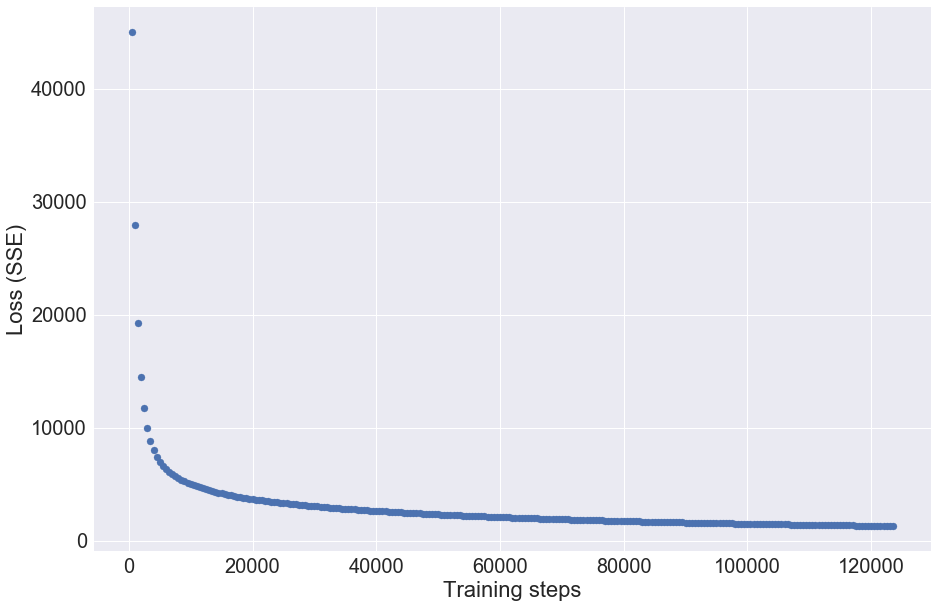

In [201]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [202]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-123500


In [203]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.93
The Mean Absolute Error: 0.87 
The Median Absolute Error: 0.70 


In [204]:
predictions

array([30.336958, 23.706419, 32.090603, ..., 22.952717, 24.697342,
       30.114582], dtype=float32)

In [205]:
predictions.size

222104

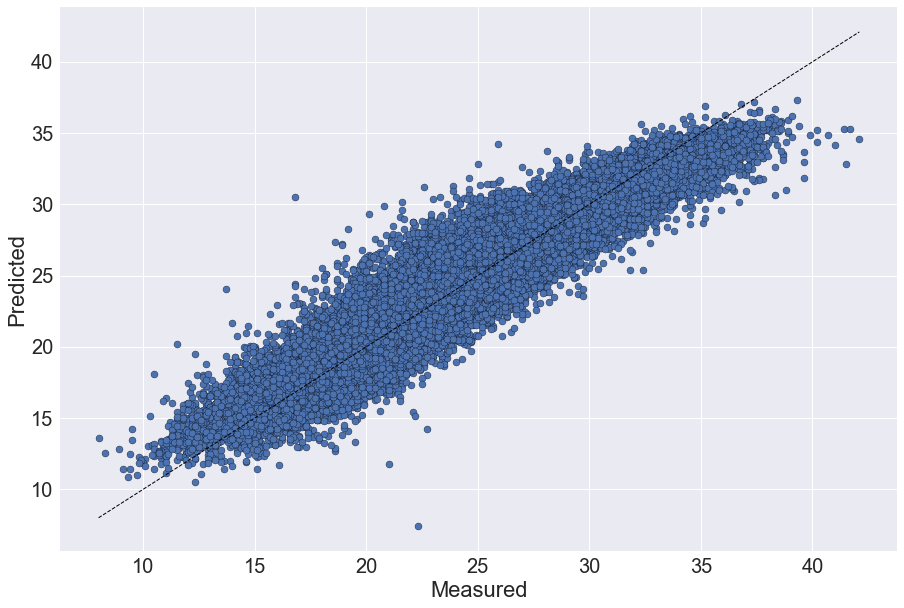

In [206]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()